In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from metrics import MCC

In [2]:
# Model name used to save the weights in h5 format. The name match with the Jupyter notebook

MODEL_NAME = 'malaria_model'

In [3]:
# DATA PATHS

TRAIN_FOLDER_PATH = '../../data/train/'
VAL_FODLER_PATH = '../../data/validation/'
#TEST_FOLDER_PATH = '../../data/test/'
TEST_FOLDER_PATH = '../../data/test_manual'
PREVIEW_IMAGES_FOLDER = '../../data/preview/'

PREDICTION_FILE_PATH = '../../data/' + MODEL_NAME + '.csv'

In [4]:
# Configure hyperparameters
img_width = 100
img_height = 100
img_depth = 3

classes = 2
batch_size = 64
num_epochs = 1
loss = "binary_crossentropy"
learning_rate = 1e-1
decay = 1e-1
momentum = 0.9

In [5]:
# MODEL TRAINING CONFIGURATION

train_datagen = ImageDataGenerator(
    rescale=1 / 255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest"
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_FOLDER_PATH,
    target_size = (img_height,img_width),
    color_mode='rgb',
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

validation_generator = validation_datagen.flow_from_directory(
    VAL_FODLER_PATH,
    target_size = (img_height, img_width),
    color_mode='rgb',
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

test_generator = test_datagen.flow_from_directory(
    TEST_FOLDER_PATH,
    target_size = (img_height, img_width),
    color_mode='rgb',
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

Found 20668 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.
Found 1376 images belonging to 2 classes.


In [6]:
# Model architecture

inputShape = (img_height, img_width, img_depth)

model = Sequential()

model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 64)        0

In [13]:
# Callbacks
mc = ModelCheckpoint('best_' + model.name + '.h5', monitor='val_MCC', mode='max', verbose=1, save_best_only=True)
es = EarlyStopping(monitor = 'val_loss', patience=5, verbose=1, mode='min')

In [14]:
# Compile the model
opt = SGD(lr=learning_rate, momentum=momentum, decay=decay / num_epochs)

model.compile(loss=loss, optimizer = opt, metrics=["accuracy", MCC])

In [15]:
# Fit the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.n // train_generator.batch_size,
    epochs = num_epochs,
    validation_data = validation_generator,
    validation_steps = validation_generator.n // validation_generator.batch_size,
    use_multiprocessing = True,
    callbacks = [mc, es]
)

321/322 [============================>.] - ETA: 0s - loss: 0.2679 - accuracy: 0.9204 - MCC: 0.8407
Epoch 00001: val_MCC improved from -inf to 0.80414, saving model to best_sequential.h5
322/322 [==============================] - 46s 143ms/step - loss: 0.2677 - accuracy: 0.9205 - MCC: 0.8409 - val_loss: 0.3464 - val_accuracy: 0.9021 - val_MCC: 0.8041


In [16]:
# Save model
model.save_weights(MODEL_NAME + '.h5')

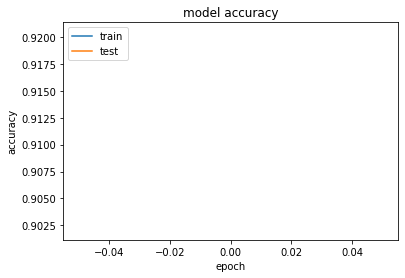

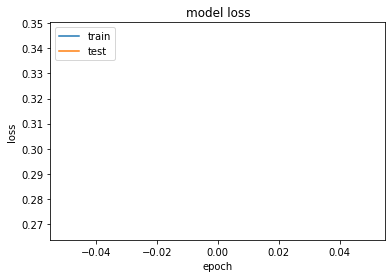

In [17]:
# Plot accuracy and loss values

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
# Evaluate the model
model.evaluate_generator(validation_generator, steps = validation_generator.n // validation_generator.batch_size)

[0.34640718695469375, 0.90207124, 0.8041424]

In [19]:
# Predictions

test_generator.reset()
predIdxs = model.predict_generator(test_generator,steps=(test_generator.n // test_generator.batch_size) + 1)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [20]:
# Show metrics

print(classification_report(test_generator.classes, predIdxs, target_names=test_generator.class_indices.keys()))

cm = confusion_matrix(test_generator.classes, predIdxs)
total = sum(sum(cm))
acc = (cm[0,0] + cm[1,1]) / total
sensitivity = cm[0,0] / (cm[0,0] + cm[0,1])
specificity = cm[1,1] / (cm[1,0] + cm[1,1])

print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

              precision    recall  f1-score   support

 parasitized       0.99      0.81      0.89       688
  uninfected       0.84      0.99      0.91       688

    accuracy                           0.90      1376
   macro avg       0.92      0.90      0.90      1376
weighted avg       0.92      0.90      0.90      1376

acc: 0.9004
sensitivity: 0.8067
specificity: 0.9942
